In [1]:
!pip install -r ../requirements.txt

You should consider upgrading via the 'c:\users\falchetto\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


# Configuration

In [2]:
ROOT_DIR = "../"
DATA_DIR = ROOT_DIR + "data/"

DATASET_2016_10a_FILENAME = DATA_DIR + "RML2016.10a_dict.pkl"

NN_NAME = 'VTCNN2V2'

DEFAULT_CONFIG_FILENAME = ROOT_DIR + "default.ini"

In [3]:
import configparser

config = configparser.ConfigParser()
config.read(DEFAULT_CONFIG_FILENAME)

NEURAL_NETWORK_NAME = config.get('NeuralNetworkNames', NN_NAME)
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

TRAINING_SET_DIMENSION = config.getfloat('TrainingValues', 'TrainingSetSplitPercentage')
DROPOUT_RATE = config.getfloat('TrainingValues', 'DropoutRate')

# Set up some params 
NB_EPOCH = config.getint('TrainingValues', 'Epochs') # number of epochs to train on
BATCH_SIZE = config.getint('TrainingValues', 'BatchSize') # training batch size

# Imports

In [4]:
import sys
sys.path.append(ROOT_DIR)

import neural_networks
import datasetlib
import traintestsplitlib
import trainlib
import evaluationlib

# Dataset

## Dataset in a pandas Dataframe

In [5]:
dataset_df = datasetlib.load_dataset_dataframe(DATASET_2016_10a_FILENAME)

## Raw dataset

In [6]:
dataset_df

,IQ signals,Modulation_Label,SNR
0,"[[-0.0059014712, -0.0023458179, -0.00074506126...",QPSK,2
1,"[[0.0050326153, 0.00094379985, -0.0018932355, ...",QPSK,2
2,"[[0.0052390713, 0.0073890695, 0.007276459, 0.0...",QPSK,2
3,"[[-0.0019859935, -0.0071501383, -0.00527185, -...",QPSK,2
4,"[[0.006674405, 0.0028359746, 0.005630027, 0.00...",QPSK,2
...,...,...,...
219995,"[[0.0062732296, -0.0050519477, 0.006672171, 0....",BPSK,-18
219996,"[[-0.003903181, -0.0015884301, -0.00633375, 2....",BPSK,-18
219997,"[[-0.0105958255, 0.005601244, -0.012161784, 0....",BPSK,-18
219998,"[[-0.002136606, 0.00995837, 0.0059440527, -0.0...",BPSK,-18


# Neural network

## Configuration

In [7]:
config = configparser.ConfigParser()
config.read(DEFAULT_CONFIG_FILENAME)

NEURAL_NETWORK_NAME = config.get('NeuralNetworkNames', NN_NAME)
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

TRAINING_SET_DIMENSION = config.getfloat('TrainingValues', 'TrainingSetSplitPercentage')
DROPOUT_RATE = config.getfloat('TrainingValues', 'DropoutRate')

# Set up some params 
NB_EPOCH = config.getint('TrainingValues', 'Epochs') # number of epochs to train on
BATCH_SIZE = config.getint('TrainingValues', 'BatchSize') # training batch size

## Data prepare

In [8]:
signals = datasetlib.signals(dataset_df)
labels = datasetlib.labels(dataset_df)

# [QPSQ, BPSK, ...]
mods = datasetlib.mods(dataset_df)
# [-18, -16, ...]
snrs = datasetlib.unique_snrs(dataset_df)

### Training and Test data partitioning

In [9]:
n_elements = len(signals)
training_set_percentage = TRAINING_SET_DIMENSION

train_index, test_index = traintestsplitlib.train_test_random_indexes(n_elements, training_set_percentage)

X_train, X_test, Y_train, Y_test = traintestsplitlib.split_x_y_train_test(signals, labels, mods, train_index, test_index)

## Build the Neural Network

In [10]:
in_shp = list(X_train.shape[1:])
print(X_train.shape)
print(in_shp)
classes = mods

(165000, 2, 128)
[2, 128]


In [11]:
model = neural_networks.rml201610a_VTCNN2_v2(in_shp)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 1, 2, 128)         0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 1, 6, 128)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 1, 2, 256)         33024     
_________________________________________________________________
dropout (Dropout)            (None, 1, 2, 256)         0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 1, 6, 256)         0         
_________________________________________________________________
conv2 (Conv2D)               (None, 1, 2, 80)          82000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 2, 80)          0

### Train the model

In [12]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = NEURAL_NETWORK_FILENAME

history, model = trainlib.train(filepath, model, X_train, Y_train, X_test, Y_test, BATCH_SIZE, NB_EPOCH)

Epoch 1/100


  1/162 [..............................] - ETA: 31:10 - loss: 2.3980

  9/162 [>.............................] - ETA: 1s - loss: 2.3977   

 17/162 [==>...........................] - ETA: 0s - loss: 2.3975

 25/162 [===>..........................] - ETA: 0s - loss: 2.3967

 33/162 [=====>........................] - ETA: 0s - loss: 2.3951

 41/162 [======>.......................] - ETA: 0s - loss: 2.3917

 49/162 [========>.....................] - ETA: 0s - loss: 2.3867

 57/162 [=========>....................] - ETA: 0s - loss: 2.3809

 66/162 [===========>..................] - ETA: 0s - loss: 2.3741

 75/162 [============>.................] - ETA: 0s - loss: 2.3676

 84/162 [==============>...............] - ETA: 0s - loss: 2.3615

 92/162 [================>.............] - ETA: 0s - loss: 2.3564

101/162 [=================>............] - ETA: 0s - loss: 2.3512

110/162 [===================>..........] - ETA: 0s - loss: 2.3463

119/162 [=====================>........] - ETA: 0s - loss: 2.3419

128/162 [======================>.......] - ETA: 0s - loss: 2.3378

137/162 [========================>.....] - ETA: 0s - loss: 2.3339

146/162 [==========================>...] - ETA: 0s - loss: 2.3303

155/162 [===========================>..] - ETA: 0s - loss: 2.3269

162/162 [==============================] - ETA: 0s - loss: 2.3245

162/162 [==============================] - 13s 10ms/step - loss: 2.3241 - val_loss: 2.2064


Epoch 2/100
  1/162 [..............................] - ETA: 0s - loss: 2.2401

 10/162 [>.............................] - ETA: 0s - loss: 2.2124

 18/162 [==>...........................] - ETA: 0s - loss: 2.2127

 27/162 [====>.........................] - ETA: 0s - loss: 2.2118

 36/162 [=====>........................] - ETA: 0s - loss: 2.2100

 45/162 [=======>......................] - ETA: 0s - loss: 2.2078

 54/162 [=========>....................] - ETA: 0s - loss: 2.2054

 63/162 [==========>...................] - ETA: 0s - loss: 2.2028

 71/162 [============>.................] - ETA: 0s - loss: 2.2005

 80/162 [=============>................] - ETA: 0s - loss: 2.1978

 89/162 [===============>..............] - ETA: 0s - loss: 2.1947

 98/162 [=================>............] - ETA: 0s - loss: 2.1915

107/162 [==================>...........] - ETA: 0s - loss: 2.1882

115/162 [====================>.........] - ETA: 0s - loss: 2.1853

124/162 [=====================>........] - ETA: 0s - loss: 2.1819

132/162 [=======================>......] - ETA: 0s - loss: 2.1789

141/162 [=========================>....] - ETA: 0s - loss: 2.1755

150/162 [==========================>...] - ETA: 0s - loss: 2.1722

159/162 [============================>.] - ETA: 0s - loss: 2.1689

162/162 [==============================] - 1s 7ms/step - loss: 2.1675 - val_loss: 1.9731


Epoch 3/100
  1/162 [..............................] - ETA: 1s - loss: 2.0145

  9/162 [>.............................] - ETA: 0s - loss: 2.0189

 17/162 [==>...........................] - ETA: 0s - loss: 2.0179

 26/162 [===>..........................] - ETA: 0s - loss: 2.0154

 35/162 [=====>........................] - ETA: 0s - loss: 2.0134

 44/162 [=======>......................] - ETA: 0s - loss: 2.0123

 53/162 [========>.....................] - ETA: 0s - loss: 2.0113

 62/162 [==========>...................] - ETA: 0s - loss: 2.0104

 70/162 [===========>..................] - ETA: 0s - loss: 2.0096

 79/162 [=============>................] - ETA: 0s - loss: 2.0086

 88/162 [===============>..............] - ETA: 0s - loss: 2.0076

 96/162 [================>.............] - ETA: 0s - loss: 2.0067

105/162 [==================>...........] - ETA: 0s - loss: 2.0058

114/162 [====================>.........] - ETA: 0s - loss: 2.0048

123/162 [=====================>........] - ETA: 0s - loss: 2.0039

132/162 [=======================>......] - ETA: 0s - loss: 2.0030

141/162 [=========================>....] - ETA: 0s - loss: 2.0021

149/162 [==========================>...] - ETA: 0s - loss: 2.0014

158/162 [============================>.] - ETA: 0s - loss: 2.0005

162/162 [==============================] - 1s 7ms/step - loss: 2.0000 - val_loss: 1.9067


Epoch 4/100
  1/162 [..............................] - ETA: 1s - loss: 1.9679

 10/162 [>.............................] - ETA: 0s - loss: 1.9702

 19/162 [==>...........................] - ETA: 0s - loss: 1.9678

 28/162 [====>.........................] - ETA: 0s - loss: 1.9666

 36/162 [=====>........................] - ETA: 0s - loss: 1.9658

 44/162 [=======>......................] - ETA: 0s - loss: 1.9649

 52/162 [========>.....................] - ETA: 0s - loss: 1.9641

 61/162 [==========>...................] - ETA: 0s - loss: 1.9633

 70/162 [===========>..................] - ETA: 0s - loss: 1.9625

 79/162 [=============>................] - ETA: 0s - loss: 1.9617

 88/162 [===============>..............] - ETA: 0s - loss: 1.9609

 97/162 [================>.............] - ETA: 0s - loss: 1.9601

106/162 [==================>...........] - ETA: 0s - loss: 1.9594

115/162 [====================>.........] - ETA: 0s - loss: 1.9587

124/162 [=====================>........] - ETA: 0s - loss: 1.9580

133/162 [=======================>......] - ETA: 0s - loss: 1.9573

142/162 [=========================>....] - ETA: 0s - loss: 1.9566

151/162 [==========================>...] - ETA: 0s - loss: 1.9559

160/162 [============================>.] - ETA: 0s - loss: 1.9553

162/162 [==============================] - 1s 7ms/step - loss: 1.9551 - val_loss: 1.8556


Epoch 5/100
  1/162 [..............................] - ETA: 1s - loss: 1.9076

  9/162 [>.............................] - ETA: 0s - loss: 1.9107

 18/162 [==>...........................] - ETA: 0s - loss: 1.9093

 27/162 [====>.........................] - ETA: 0s - loss: 1.9095

 36/162 [=====>........................] - ETA: 0s - loss: 1.9099

 45/162 [=======>......................] - ETA: 0s - loss: 1.9100

 54/162 [=========>....................] - ETA: 0s - loss: 1.9102

 63/162 [==========>...................] - ETA: 0s - loss: 1.9103

 72/162 [============>.................] - ETA: 0s - loss: 1.9103

 81/162 [==============>...............] - ETA: 0s - loss: 1.9100

 90/162 [===============>..............] - ETA: 0s - loss: 1.9097

 99/162 [=================>............] - ETA: 0s - loss: 1.9094

108/162 [===================>..........] - ETA: 0s - loss: 1.9090



117/162 [====================>.........] - ETA: 0s - loss: 1.9087

126/162 [======================>.......] - ETA: 0s - loss: 1.9083

135/162 [========================>.....] - ETA: 0s - loss: 1.9079

144/162 [=========================>....] - ETA: 0s - loss: 1.9076

153/162 [===========================>..] - ETA: 0s - loss: 1.9072

161/162 [============================>.] - ETA: 0s - loss: 1.9069

162/162 [==============================] - 1s 7ms/step - loss: 1.9068 - val_loss: 1.8161


Epoch 6/100
  1/162 [..............................] - ETA: 0s - loss: 1.8645

  9/162 [>.............................] - ETA: 0s - loss: 1.8742

 18/162 [==>...........................] - ETA: 0s - loss: 1.8780

 27/162 [====>.........................] - ETA: 0s - loss: 1.8789

 36/162 [=====>........................] - ETA: 0s - loss: 1.8799

 45/162 [=======>......................] - ETA: 0s - loss: 1.8799

 54/162 [=========>....................] - ETA: 0s - loss: 1.8801

 63/162 [==========>...................] - ETA: 0s - loss: 1.8803

 72/162 [============>.................] - ETA: 0s - loss: 1.8804

 81/162 [==============>...............] - ETA: 0s - loss: 1.8803

 90/162 [===============>..............] - ETA: 0s - loss: 1.8800

 98/162 [=================>............] - ETA: 0s - loss: 1.8798

107/162 [==================>...........] - ETA: 0s - loss: 1.8795

115/162 [====================>.........] - ETA: 0s - loss: 1.8792

124/162 [=====================>........] - ETA: 0s - loss: 1.8789



133/162 [=======================>......] - ETA: 0s - loss: 1.8786

142/162 [=========================>....] - ETA: 0s - loss: 1.8783

151/162 [==========================>...] - ETA: 0s - loss: 1.8780

159/162 [============================>.] - ETA: 0s - loss: 1.8778

162/162 [==============================] - 1s 7ms/step - loss: 1.8776 - val_loss: 1.7951


Epoch 7/100
  1/162 [..............................] - ETA: 1s - loss: 1.8737

 10/162 [>.............................] - ETA: 0s - loss: 1.8697

 19/162 [==>...........................] - ETA: 0s - loss: 1.8683

 28/162 [====>.........................] - ETA: 0s - loss: 1.8676

 37/162 [=====>........................] - ETA: 0s - loss: 1.8665

 46/162 [=======>......................] - ETA: 0s - loss: 1.8655

 55/162 [=========>....................] - ETA: 0s - loss: 1.8650

 64/162 [==========>...................] - ETA: 0s - loss: 1.8645

 73/162 [============>.................] - ETA: 0s - loss: 1.8641

 81/162 [==============>...............] - ETA: 0s - loss: 1.8638

 90/162 [===============>..............] - ETA: 0s - loss: 1.8633

 98/162 [=================>............] - ETA: 0s - loss: 1.8629

106/162 [==================>...........] - ETA: 0s - loss: 1.8625

115/162 [====================>.........] - ETA: 0s - loss: 1.8621

124/162 [=====================>........] - ETA: 0s - loss: 1.8617

133/162 [=======================>......] - ETA: 0s - loss: 1.8613

141/162 [=========================>....] - ETA: 0s - loss: 1.8610

150/162 [==========================>...] - ETA: 0s - loss: 1.8607

159/162 [============================>.] - ETA: 0s - loss: 1.8604

162/162 [==============================] - 1s 7ms/step - loss: 1.8603 - val_loss: 1.7763


Epoch 8/100


  1/162 [..............................] - ETA: 1s - loss: 1.8281

 10/162 [>.............................] - ETA: 0s - loss: 1.8423

 19/162 [==>...........................] - ETA: 0s - loss: 1.8453

 28/162 [====>.........................] - ETA: 0s - loss: 1.8474

 36/162 [=====>........................] - ETA: 0s - loss: 1.8477

 44/162 [=======>......................] - ETA: 0s - loss: 1.8478

 52/162 [========>.....................] - ETA: 0s - loss: 1.8478

 61/162 [==========>...................] - ETA: 0s - loss: 1.8474

 70/162 [===========>..................] - ETA: 0s - loss: 1.8468

 79/162 [=============>................] - ETA: 0s - loss: 1.8464

 88/162 [===============>..............] - ETA: 0s - loss: 1.8461

 96/162 [================>.............] - ETA: 0s - loss: 1.8459

105/162 [==================>...........] - ETA: 0s - loss: 1.8458

114/162 [====================>.........] - ETA: 0s - loss: 1.8456

123/162 [=====================>........] - ETA: 0s - loss: 1.8454

131/162 [=======================>......] - ETA: 0s - loss: 1.8453

140/162 [========================>.....] - ETA: 0s - loss: 1.8452

148/162 [==========================>...] - ETA: 0s - loss: 1.8451

157/162 [============================>.] - ETA: 0s - loss: 1.8450

162/162 [==============================] - 1s 7ms/step - loss: 1.8450 - val_loss: 1.7645


Epoch 9/100
  1/162 [..............................] - ETA: 1s - loss: 1.8180

 10/162 [>.............................] - ETA: 0s - loss: 1.8325

 18/162 [==>...........................] - ETA: 0s - loss: 1.8355

 27/162 [====>.........................] - ETA: 0s - loss: 1.8355

 35/162 [=====>........................] - ETA: 0s - loss: 1.8353

 44/162 [=======>......................] - ETA: 0s - loss: 1.8348

 53/162 [========>.....................] - ETA: 0s - loss: 1.8347

 62/162 [==========>...................] - ETA: 0s - loss: 1.8346

 71/162 [============>.................] - ETA: 0s - loss: 1.8344

 80/162 [=============>................] - ETA: 0s - loss: 1.8343

 89/162 [===============>..............] - ETA: 0s - loss: 1.8342

 97/162 [================>.............] - ETA: 0s - loss: 1.8339

105/162 [==================>...........] - ETA: 0s - loss: 1.8337

114/162 [====================>.........] - ETA: 0s - loss: 1.8334

123/162 [=====================>........] - ETA: 0s - loss: 1.8332

132/162 [=======================>......] - ETA: 0s - loss: 1.8330

141/162 [=========================>....] - ETA: 0s - loss: 1.8328

150/162 [==========================>...] - ETA: 0s - loss: 1.8327

158/162 [============================>.] - ETA: 0s - loss: 1.8326

162/162 [==============================] - 1s 7ms/step - loss: 1.8325 - val_loss: 1.7590


Epoch 10/100
  1/162 [..............................] - ETA: 1s - loss: 1.8212

 10/162 [>.............................] - ETA: 0s - loss: 1.8356

 19/162 [==>...........................] - ETA: 0s - loss: 1.8370

 27/162 [====>.........................] - ETA: 0s - loss: 1.8358

 36/162 [=====>........................] - ETA: 0s - loss: 1.8343

 45/162 [=======>......................] - ETA: 0s - loss: 1.8337

 54/162 [=========>....................] - ETA: 0s - loss: 1.8329

 62/162 [==========>...................] - ETA: 0s - loss: 1.8320

 70/162 [===========>..................] - ETA: 0s - loss: 1.8312

 78/162 [=============>................] - ETA: 0s - loss: 1.8308

 87/162 [===============>..............] - ETA: 0s - loss: 1.8304

 96/162 [================>.............] - ETA: 0s - loss: 1.8300

105/162 [==================>...........] - ETA: 0s - loss: 1.8298

114/162 [====================>.........] - ETA: 0s - loss: 1.8295

123/162 [=====================>........] - ETA: 0s - loss: 1.8292

132/162 [=======================>......] - ETA: 0s - loss: 1.8288

141/162 [=========================>....] - ETA: 0s - loss: 1.8285

149/162 [==========================>...] - ETA: 0s - loss: 1.8282

157/162 [============================>.] - ETA: 0s - loss: 1.8279

162/162 [==============================] - 1s 7ms/step - loss: 1.8277 - val_loss: 1.7566


Epoch 11/100
  1/162 [..............................] - ETA: 1s - loss: 1.8356

  9/162 [>.............................] - ETA: 0s - loss: 1.8224

 18/162 [==>...........................] - ETA: 0s - loss: 1.8202

 27/162 [====>.........................] - ETA: 0s - loss: 1.8198

 35/162 [=====>........................] - ETA: 0s - loss: 1.8193

 43/162 [======>.......................] - ETA: 0s - loss: 1.8187

 51/162 [========>.....................] - ETA: 0s - loss: 1.8181

 60/162 [==========>...................] - ETA: 0s - loss: 1.8174

 69/162 [===========>..................] - ETA: 0s - loss: 1.8169

 78/162 [=============>................] - ETA: 0s - loss: 1.8166

 87/162 [===============>..............] - ETA: 0s - loss: 1.8163

 96/162 [================>.............] - ETA: 0s - loss: 1.8162

105/162 [==================>...........] - ETA: 0s - loss: 1.8162

114/162 [====================>.........] - ETA: 0s - loss: 1.8161

123/162 [=====================>........] - ETA: 0s - loss: 1.8161

132/162 [=======================>......] - ETA: 0s - loss: 1.8160

141/162 [=========================>....] - ETA: 0s - loss: 1.8160

150/162 [==========================>...] - ETA: 0s - loss: 1.8158

159/162 [============================>.] - ETA: 0s - loss: 1.8157

162/162 [==============================] - 1s 7ms/step - loss: 1.8157 - val_loss: 1.7380


Epoch 12/100
  1/162 [..............................] - ETA: 1s - loss: 1.8345

  9/162 [>.............................] - ETA: 0s - loss: 1.8250

 17/162 [==>...........................] - ETA: 0s - loss: 1.8200

 26/162 [===>..........................] - ETA: 0s - loss: 1.8162

 35/162 [=====>........................] - ETA: 0s - loss: 1.8135

 44/162 [=======>......................] - ETA: 0s - loss: 1.8125

 53/162 [========>.....................] - ETA: 0s - loss: 1.8118

 62/162 [==========>...................] - ETA: 0s - loss: 1.8114

 71/162 [============>.................] - ETA: 0s - loss: 1.8110

 80/162 [=============>................] - ETA: 0s - loss: 1.8108

 89/162 [===============>..............] - ETA: 0s - loss: 1.8107

 98/162 [=================>............] - ETA: 0s - loss: 1.8107

107/162 [==================>...........] - ETA: 0s - loss: 1.8106

115/162 [====================>.........] - ETA: 0s - loss: 1.8105

124/162 [=====================>........] - ETA: 0s - loss: 1.8103

133/162 [=======================>......] - ETA: 0s - loss: 1.8102

142/162 [=========================>....] - ETA: 0s - loss: 1.8100

151/162 [==========================>...] - ETA: 0s - loss: 1.8098

160/162 [============================>.] - ETA: 0s - loss: 1.8096

162/162 [==============================] - 1s 7ms/step - loss: 1.8096 - val_loss: 1.7343


Epoch 13/100
  1/162 [..............................] - ETA: 1s - loss: 1.8055

 10/162 [>.............................] - ETA: 0s - loss: 1.8033

 19/162 [==>...........................] - ETA: 0s - loss: 1.8028

 28/162 [====>.........................] - ETA: 0s - loss: 1.8033

 37/162 [=====>........................] - ETA: 0s - loss: 1.8040

 46/162 [=======>......................] - ETA: 0s - loss: 1.8044

 55/162 [=========>....................] - ETA: 0s - loss: 1.8045

 64/162 [==========>...................] - ETA: 0s - loss: 1.8042

 72/162 [============>.................] - ETA: 0s - loss: 1.8041

 81/162 [==============>...............] - ETA: 0s - loss: 1.8039

 90/162 [===============>..............] - ETA: 0s - loss: 1.8037

 99/162 [=================>............] - ETA: 0s - loss: 1.8036

108/162 [===================>..........] - ETA: 0s - loss: 1.8033

117/162 [====================>.........] - ETA: 0s - loss: 1.8031

126/162 [======================>.......] - ETA: 0s - loss: 1.8029

135/162 [========================>.....] - ETA: 0s - loss: 1.8026

144/162 [=========================>....] - ETA: 0s - loss: 1.8024

153/162 [===========================>..] - ETA: 0s - loss: 1.8023

162/162 [==============================] - ETA: 0s - loss: 1.8022

162/162 [==============================] - 1s 7ms/step - loss: 1.8022 - val_loss: 1.7300


Epoch 14/100
  1/162 [..............................] - ETA: 1s - loss: 1.7865

  9/162 [>.............................] - ETA: 0s - loss: 1.7923

 17/162 [==>...........................] - ETA: 0s - loss: 1.7930

 26/162 [===>..........................] - ETA: 0s - loss: 1.7946

 35/162 [=====>........................] - ETA: 0s - loss: 1.7951

 44/162 [=======>......................] - ETA: 0s - loss: 1.7958

 53/162 [========>.....................] - ETA: 0s - loss: 1.7959

 62/162 [==========>...................] - ETA: 0s - loss: 1.7959

 70/162 [===========>..................] - ETA: 0s - loss: 1.7961

 79/162 [=============>................] - ETA: 0s - loss: 1.7963



 88/162 [===============>..............] - ETA: 0s - loss: 1.7964

 96/162 [================>.............] - ETA: 0s - loss: 1.7963

105/162 [==================>...........] - ETA: 0s - loss: 1.7962

114/162 [====================>.........] - ETA: 0s - loss: 1.7962

122/162 [=====================>........] - ETA: 0s - loss: 1.7962

131/162 [=======================>......] - ETA: 0s - loss: 1.7961

140/162 [========================>.....] - ETA: 0s - loss: 1.7960

149/162 [==========================>...] - ETA: 0s - loss: 1.7958

158/162 [============================>.] - ETA: 0s - loss: 1.7957

162/162 [==============================] - 1s 7ms/step - loss: 1.7956 - val_loss: 1.7272


Epoch 15/100
  1/162 [..............................] - ETA: 1s - loss: 1.7848

  9/162 [>.............................] - ETA: 1s - loss: 1.7801

 18/162 [==>...........................] - ETA: 0s - loss: 1.7838

 27/162 [====>.........................] - ETA: 0s - loss: 1.7846

 36/162 [=====>........................] - ETA: 0s - loss: 1.7848

 44/162 [=======>......................] - ETA: 0s - loss: 1.7851

 53/162 [========>.....................] - ETA: 0s - loss: 1.7855

 61/162 [==========>...................] - ETA: 0s - loss: 1.7857

 70/162 [===========>..................] - ETA: 0s - loss: 1.7858

 79/162 [=============>................] - ETA: 0s - loss: 1.7861

 88/162 [===============>..............] - ETA: 0s - loss: 1.7863

 97/162 [================>.............] - ETA: 0s - loss: 1.7863

106/162 [==================>...........] - ETA: 0s - loss: 1.7863

115/162 [====================>.........] - ETA: 0s - loss: 1.7862

124/162 [=====================>........] - ETA: 0s - loss: 1.7862

133/162 [=======================>......] - ETA: 0s - loss: 1.7862

142/162 [=========================>....] - ETA: 0s - loss: 1.7862

151/162 [==========================>...] - ETA: 0s - loss: 1.7863

160/162 [============================>.] - ETA: 0s - loss: 1.7864

162/162 [==============================] - 1s 7ms/step - loss: 1.7864 - val_loss: 1.7254


Epoch 16/100


  1/162 [..............................] - ETA: 1s - loss: 1.8088

 10/162 [>.............................] - ETA: 0s - loss: 1.7873

 18/162 [==>...........................] - ETA: 0s - loss: 1.7862

 27/162 [====>.........................] - ETA: 0s - loss: 1.7860

 36/162 [=====>........................] - ETA: 0s - loss: 1.7857

 44/162 [=======>......................] - ETA: 0s - loss: 1.7857

 53/162 [========>.....................] - ETA: 0s - loss: 1.7857

 62/162 [==========>...................] - ETA: 0s - loss: 1.7857

 71/162 [============>.................] - ETA: 0s - loss: 1.7858

 80/162 [=============>................] - ETA: 0s - loss: 1.7858

 89/162 [===============>..............] - ETA: 0s - loss: 1.7859

 98/162 [=================>............] - ETA: 0s - loss: 1.7859

107/162 [==================>...........] - ETA: 0s - loss: 1.7859

116/162 [====================>.........] - ETA: 0s - loss: 1.7858

125/162 [======================>.......] - ETA: 0s - loss: 1.7858

134/162 [=======================>......] - ETA: 0s - loss: 1.7858

143/162 [=========================>....] - ETA: 0s - loss: 1.7857

152/162 [===========================>..] - ETA: 0s - loss: 1.7857

161/162 [============================>.] - ETA: 0s - loss: 1.7857

162/162 [==============================] - 1s 7ms/step - loss: 1.7856 - val_loss: 1.7179


Epoch 17/100
  1/162 [..............................] - ETA: 1s - loss: 1.7941

  9/162 [>.............................] - ETA: 0s - loss: 1.7840

 18/162 [==>...........................] - ETA: 0s - loss: 1.7799

 27/162 [====>.........................] - ETA: 0s - loss: 1.7792

 36/162 [=====>........................] - ETA: 0s - loss: 1.7798

 44/162 [=======>......................] - ETA: 0s - loss: 1.7800

 53/162 [========>.....................] - ETA: 0s - loss: 1.7802

 62/162 [==========>...................] - ETA: 0s - loss: 1.7801

 71/162 [============>.................] - ETA: 0s - loss: 1.7798

 79/162 [=============>................] - ETA: 0s - loss: 1.7798

 88/162 [===============>..............] - ETA: 0s - loss: 1.7797

 97/162 [================>.............] - ETA: 0s - loss: 1.7796

106/162 [==================>...........] - ETA: 0s - loss: 1.7795

115/162 [====================>.........] - ETA: 0s - loss: 1.7795

124/162 [=====================>........] - ETA: 0s - loss: 1.7796

132/162 [=======================>......] - ETA: 0s - loss: 1.7796

140/162 [========================>.....] - ETA: 0s - loss: 1.7797

148/162 [==========================>...] - ETA: 0s - loss: 1.7797

157/162 [============================>.] - ETA: 0s - loss: 1.7798

162/162 [==============================] - 1s 7ms/step - loss: 1.7798 - val_loss: 1.7195


Epoch 18/100
  1/162 [..............................] - ETA: 0s - loss: 1.8144

 10/162 [>.............................] - ETA: 0s - loss: 1.8006

 19/162 [==>...........................] - ETA: 0s - loss: 1.7945

 28/162 [====>.........................] - ETA: 0s - loss: 1.7921

 37/162 [=====>........................] - ETA: 0s - loss: 1.7908

 46/162 [=======>......................] - ETA: 0s - loss: 1.7897

 54/162 [=========>....................] - ETA: 0s - loss: 1.7888

 62/162 [==========>...................] - ETA: 0s - loss: 1.7880

 71/162 [============>.................] - ETA: 0s - loss: 1.7871

 80/162 [=============>................] - ETA: 0s - loss: 1.7862

 89/162 [===============>..............] - ETA: 0s - loss: 1.7855

 98/162 [=================>............] - ETA: 0s - loss: 1.7848

107/162 [==================>...........] - ETA: 0s - loss: 1.7842

116/162 [====================>.........] - ETA: 0s - loss: 1.7838

124/162 [=====================>........] - ETA: 0s - loss: 1.7834

133/162 [=======================>......] - ETA: 0s - loss: 1.7830

141/162 [=========================>....] - ETA: 0s - loss: 1.7827

149/162 [==========================>...] - ETA: 0s - loss: 1.7825

158/162 [============================>.] - ETA: 0s - loss: 1.7822

162/162 [==============================] - 1s 7ms/step - loss: 1.7821 - val_loss: 1.7146


Epoch 19/100
  1/162 [..............................] - ETA: 1s - loss: 1.7707

  9/162 [>.............................] - ETA: 0s - loss: 1.7650

 17/162 [==>...........................] - ETA: 0s - loss: 1.7672

 26/162 [===>..........................] - ETA: 0s - loss: 1.7690

 35/162 [=====>........................] - ETA: 0s - loss: 1.7709

 44/162 [=======>......................] - ETA: 0s - loss: 1.7718

 53/162 [========>.....................] - ETA: 0s - loss: 1.7719

 62/162 [==========>...................] - ETA: 0s - loss: 1.7720

 71/162 [============>.................] - ETA: 0s - loss: 1.7722

 80/162 [=============>................] - ETA: 0s - loss: 1.7725

 88/162 [===============>..............] - ETA: 0s - loss: 1.7727

 97/162 [================>.............] - ETA: 0s - loss: 1.7727

105/162 [==================>...........] - ETA: 0s - loss: 1.7728

114/162 [====================>.........] - ETA: 0s - loss: 1.7730

123/162 [=====================>........] - ETA: 0s - loss: 1.7731

132/162 [=======================>......] - ETA: 0s - loss: 1.7732

141/162 [=========================>....] - ETA: 0s - loss: 1.7733

149/162 [==========================>...] - ETA: 0s - loss: 1.7733

158/162 [============================>.] - ETA: 0s - loss: 1.7733

162/162 [==============================] - 1s 7ms/step - loss: 1.7733 - val_loss: 1.7161


Epoch 20/100
  1/162 [..............................] - ETA: 0s - loss: 1.7878

 10/162 [>.............................] - ETA: 0s - loss: 1.7791

 19/162 [==>...........................] - ETA: 0s - loss: 1.7753

 28/162 [====>.........................] - ETA: 0s - loss: 1.7726

 37/162 [=====>........................] - ETA: 0s - loss: 1.7716

 46/162 [=======>......................] - ETA: 0s - loss: 1.7710

 55/162 [=========>....................] - ETA: 0s - loss: 1.7703

 63/162 [==========>...................] - ETA: 0s - loss: 1.7700

 72/162 [============>.................] - ETA: 0s - loss: 1.7697

 80/162 [=============>................] - ETA: 0s - loss: 1.7694

 88/162 [===============>..............]

 - ETA: 0s - loss: 1.7691



 96/162 [================>.............] - ETA: 0s - loss: 1.7689

105/162 [==================>...........] - ETA: 0s - loss: 1.7687

114/162 [====================>.........] - ETA: 0s - loss: 1.7685

123/162 [=====================>........] - ETA: 0s - loss: 1.7684

132/162 [=======================>......] - ETA: 0s - loss: 1.7682

141/162 [=========================>....] - ETA: 0s - loss: 1.7682

150/162 [==========================>...] - ETA: 0s - loss: 1.7681

158/162 [============================>.] - ETA: 0s - loss: 1.7681

162/162 [==============================] - 1s 7ms/step - loss: 1.7681 - val_loss: 1.7084


Epoch 21/100
  1/162 [..............................] - ETA: 1s - loss: 1.7825

 10/162 [>.............................] - ETA: 0s - loss: 1.7782

 18/162 [==>...........................] - ETA: 0s - loss: 1.7749

 27/162 [====>.........................] - ETA: 0s - loss: 1.7728

 36/162 [=====>........................] - ETA: 0s - loss: 1.7719

 44/162 [=======>......................] - ETA: 0s - loss: 1.7715

 53/162 [========>.....................] - ETA: 0s - loss: 1.7713

 62/162 [==========>...................] - ETA: 0s - loss: 1.7710

 71/162 [============>.................] - ETA: 0s - loss: 1.7706

 80/162 [=============>................] - ETA: 0s - loss: 1.7703

 89/162 [===============>..............] - ETA: 0s - loss: 1.7699

 98/162 [=================>............] - ETA: 0s - loss: 1.7696

107/162 [==================>...........] - ETA: 0s - loss: 1.7693

116/162 [====================>.........] - ETA: 0s - loss: 1.7691

125/162 [======================>.......] - ETA: 0s - loss: 1.7689

134/162 [=======================>......] - ETA: 0s - loss: 1.7687

143/162 [=========================>....] - ETA: 0s - loss: 1.7686

152/162 [===========================>..] - ETA: 0s - loss: 1.7684

160/162 [============================>.] - ETA: 0s - loss: 1.7684

162/162 [==============================] - 1s 7ms/step - loss: 1.7683 - val_loss: 1.7084


Epoch 22/100
  1/162 [..............................] - ETA: 0s - loss: 1.7665

 10/162 [>.............................] - ETA: 0s - loss: 1.7615

 19/162 [==>...........................] - ETA: 0s - loss: 1.7614

 27/162 [====>.........................] - ETA: 0s - loss: 1.7607

 36/162 [=====>........................] - ETA: 0s - loss: 1.7601

 45/162 [=======>......................] - ETA: 0s - loss: 1.7601

 54/162 [=========>....................] - ETA: 0s - loss: 1.7599

 63/162 [==========>...................] - ETA: 0s - loss: 1.7599

 72/162 [============>.................] - ETA: 0s - loss: 1.7601

 81/162 [==============>...............] - ETA: 0s - loss: 1.7604

 90/162 [===============>..............] - ETA: 0s - loss: 1.7607

 99/162 [=================>............] - ETA: 0s - loss: 1.7610

108/162 [===================>..........] - ETA: 0s - loss: 1.7612

117/162 [====================>.........] - ETA: 0s - loss: 1.7614

126/162 [======================>.......] - ETA: 0s - loss: 1.7615

135/162 [========================>.....] - ETA: 0s - loss: 1.7616

144/162 [=========================>....] - ETA: 0s - loss: 1.7617

152/162 [===========================>..] - ETA: 0s - loss: 1.7617

161/162 [============================>.] - ETA: 0s - loss: 1.7618

162/162 [==============================] - 1s 7ms/step - loss: 1.7618 - val_loss: 1.7053


Epoch 23/100
  1/162 [..............................] - ETA: 1s - loss: 1.7620

  9/162 [>.............................] - ETA: 0s - loss: 1.7674

 18/162 [==>...........................] - ETA: 0s - loss: 1.7672

 27/162 [====>.........................] - ETA: 0s - loss: 1.7678

 36/162 [=====>........................] - ETA: 0s - loss: 1.7676

 44/162 [=======>......................] - ETA: 0s - loss: 1.7676

 53/162 [========>.....................] - ETA: 0s - loss: 1.7674

 62/162 [==========>...................] - ETA: 0s - loss: 1.7668

 71/162 [============>.................] - ETA: 0s - loss: 1.7663

 80/162 [=============>................] - ETA: 0s - loss: 1.7660

 89/162 [===============>..............] - ETA: 0s - loss: 1.7658

 98/162 [=================>............] - ETA: 0s - loss: 1.7654

107/162 [==================>...........] - ETA: 0s - loss: 1.7651

116/162 [====================>.........] - ETA: 0s - loss: 1.7648

125/162 [======================>.......] - ETA: 0s - loss: 1.7645

134/162 [=======================>......] - ETA: 0s - loss: 1.7643

142/162 [=========================>....] - ETA: 0s - loss: 1.7641

150/162 [==========================>...] - ETA: 0s - loss: 1.7639

158/162 [============================>.] - ETA: 0s - loss: 1.7638

162/162 [==============================] - 1s 7ms/step - loss: 1.7636 - val_loss: 1.7001


Epoch 24/100
  1/162 [..............................] - ETA: 1s - loss: 1.7679

 10/162 [>.............................] - ETA: 0s - loss: 1.7673

 19/162 [==>...........................] - ETA: 0s - loss: 1.7675

 28/162 [====>.........................] - ETA: 0s - loss: 1.7680

 37/162 [=====>........................] - ETA: 0s - loss: 1.7678

 46/162 [=======>......................] - ETA: 0s - loss: 1.7675

 55/162 [=========>....................] - ETA: 0s - loss: 1.7672

 64/162 [==========>...................] - ETA: 0s - loss: 1.7669

 73/162 [============>.................] - ETA: 0s - loss: 1.7664

 81/162 [==============>...............] - ETA: 0s - loss: 1.7661

 89/162 [===============>..............] - ETA: 0s - loss: 1.7657

 97/162 [================>.............] - ETA: 0s - loss: 1.7652

 98/162 [=================>............] - ETA: 0s - loss: 1.7652



106/162 [==================>...........] - ETA: 0s - loss: 1.7647

114/162 [====================>.........] - ETA: 0s - loss: 1.7643

123/162 [=====================>........] - ETA: 0s - loss: 1.7638

132/162 [=======================>......] - ETA: 0s - loss: 1.7635

141/162 [=========================>....] - ETA: 0s - loss: 1.7632

150/162 [==========================>...] - ETA: 0s - loss: 1.7630

159/162 [============================>.] - ETA: 0s - loss: 1.7628

162/162 [==============================] - 1s 8ms/step - loss: 1.7628 - val_loss: 1.7044


Epoch 25/100
  1/162 [..............................] - ETA: 0s - loss: 1.7595

 10/162 [>.............................] - ETA: 0s - loss: 1.7531

 18/162 [==>...........................] - ETA: 0s - loss: 1.7531

 26/162 [===>..........................] - ETA: 0s - loss: 1.7531

 34/162 [=====>........................] - ETA: 0s - loss: 1.7523

 43/162 [======>.......................] - ETA: 0s - loss: 1.7518

 52/162 [========>.....................] - ETA: 0s - loss: 1.7516

 61/162 [==========>...................] - ETA: 0s - loss: 1.7519

 70/162 [===========>..................] - ETA: 0s - loss: 1.7520

 79/162 [=============>................] - ETA: 0s - loss: 1.7523

 87/162 [===============>..............] - ETA: 0s - loss: 1.7525

 96/162 [================>.............] - ETA: 0s - loss: 1.7527

105/162 [==================>...........] - ETA: 0s - loss: 1.7530

114/162 [====================>.........] - ETA: 0s - loss: 1.7532

123/162 [=====================>........] - ETA: 0s - loss: 1.7534

132/162 [=======================>......] - ETA: 0s - loss: 1.7535

141/162 [=========================>....] - ETA: 0s - loss: 1.7536

150/162 [==========================>...] - ETA: 0s - loss: 1.7538

159/162 [============================>.] - ETA: 0s - loss: 1.7539

162/162 [==============================] - 1s 7ms/step - loss: 1.7539 - val_loss: 1.7010


Epoch 26/100
  1/162 [..............................] - ETA: 0s - loss: 1.8142

 10/162 [>.............................] - ETA: 0s - loss: 1.7675

 18/162 [==>...........................] - ETA: 0s - loss: 1.7645

 27/162 [====>.........................] - ETA: 0s - loss: 1.7631

 36/162 [=====>........................] - ETA: 0s - loss: 1.7617

 45/162 [=======>......................] - ETA: 0s - loss: 1.7604

 54/162 [=========>....................] - ETA: 0s - loss: 1.7592

 63/162 [==========>...................] - ETA: 0s - loss: 1.7579

 71/162 [============>.................] - ETA: 0s - loss: 1.7571

 80/162 [=============>................] - ETA: 0s - loss: 1.7566

 89/162 [===============>..............] - ETA: 0s - loss: 1.7563

 98/162 [=================>............] - ETA: 0s - loss: 1.7563

107/162 [==================>...........] - ETA: 0s - loss: 1.7562

116/162 [====================>.........] - ETA: 0s - loss: 1.7561

125/162 [======================>.......] - ETA: 0s - loss: 1.7561

134/162 [=======================>......] - ETA: 0s - loss: 1.7560

143/162 [=========================>....] - ETA: 0s - loss: 1.7560

152/162 [===========================>..] - ETA: 0s - loss: 1.7559

161/162 [============================>.] - ETA: 0s - loss: 1.7559

162/162 [==============================] - 1s 7ms/step - loss: 1.7558 - val_loss: 1.6955


Epoch 27/100


  1/162 [..............................] - ETA: 1s - loss: 1.7622

 10/162 [>.............................] - ETA: 0s - loss: 1.7580

 19/162 [==>...........................] - ETA: 0s - loss: 1.7582

 28/162 [====>.........................] - ETA: 0s - loss: 1.7585

 37/162 [=====>........................] - ETA: 0s - loss: 1.7589

 46/162 [=======>......................] - ETA: 0s - loss: 1.7589

 54/162 [=========>....................] - ETA: 0s - loss: 1.7585

 63/162 [==========>...................] - ETA: 0s - loss: 1.7583

 72/162 [============>.................] - ETA: 0s - loss: 1.7581

 81/162 [==============>...............] - ETA: 0s - loss: 1.7578

 89/162 [===============>..............] - ETA: 0s - loss: 1.7575

 98/162 [=================>............] - ETA: 0s - loss: 1.7570

107/162 [==================>...........] - ETA: 0s - loss: 1.7565

116/162 [====================>.........] - ETA: 0s - loss: 1.7562

125/162 [======================>.......] - ETA: 0s - loss: 1.7558

134/162 [=======================>......] - ETA: 0s - loss: 1.7555

142/162 [=========================>....] - ETA: 0s - loss: 1.7553

151/162 [==========================>...] - ETA: 0s - loss: 1.7551

160/162 [============================>.] - ETA: 0s - loss: 1.7549

162/162 [==============================] - 1s 7ms/step - loss: 1.7549 - val_loss: 1.6982


Epoch 28/100
  1/162 [..............................] - ETA: 0s - loss: 1.6988

  9/162 [>.............................] - ETA: 0s - loss: 1.7269

 18/162 [==>...........................] - ETA: 0s - loss: 1.7297

 27/162 [====>.........................] - ETA: 0s - loss: 1.7334

 36/162 [=====>........................] - ETA: 0s - loss: 1.7356

 45/162 [=======>......................] - ETA: 0s - loss: 1.7369

 54/162 [=========>....................] - ETA: 0s - loss: 1.7381

 62/162 [==========>...................] - ETA: 0s - loss: 1.7391

 71/162 [============>.................] - ETA: 0s - loss: 1.7399

 79/162 [=============>................] - ETA: 0s - loss: 1.7405

 87/162 [===============>..............] - ETA: 0s - loss: 1.7409

 96/162 [================>.............] - ETA: 0s - loss: 1.7413

105/162 [==================>...........] - ETA: 0s - loss: 1.7416

114/162 [====================>.........] - ETA: 0s - loss: 1.7421

122/162 [=====================>........] - ETA: 0s - loss: 1.7425

131/162 [=======================>......] - ETA: 0s - loss: 1.7429

139/162 [========================>.....] - ETA: 0s - loss: 1.7433

148/162 [==========================>...] - ETA: 0s - loss: 1.7437



156/162 [===========================>..] - ETA: 0s - loss: 1.7440

162/162 [==============================] - 1s 7ms/step - loss: 1.7443 - val_loss: 1.6930


Epoch 29/100
  1/162 [..............................] - ETA: 0s - loss: 1.7616

  9/162 [>.............................] - ETA: 0s - loss: 1.7638

 17/162 [==>...........................] - ETA: 0s - loss: 1.7589

 26/162 [===>..........................] - ETA: 0s - loss: 1.7549

 35/162 [=====>........................] - ETA: 0s - loss: 1.7532

 44/162 [=======>......................] - ETA: 0s - loss: 1.7524

 53/162 [========>.....................] - ETA: 0s - loss: 1.7516

 62/162 [==========>...................] - ETA: 0s - loss: 1.7509

 71/162 [============>.................] - ETA: 0s - loss: 1.7503

 80/162 [=============>................] - ETA: 0s - loss: 1.7499

 89/162 [===============>..............] - ETA: 0s - loss: 1.7497

 98/162 [=================>............]

 - ETA: 0s - loss: 1.7495

107/162 [==================>...........] - ETA: 0s - loss: 1.7494

116/162 [====================>.........] - ETA: 0s - loss: 1.7492

125/162 [======================>.......] - ETA: 0s - loss: 1.7490

134/162 [=======================>......] - ETA: 0s - loss: 1.7489

143/162 [=========================>....] - ETA: 0s - loss: 1.7488

151/162 [==========================>...] - ETA: 0s - loss: 1.7486

160/162 [============================>.] - ETA: 0s - loss: 1.7485

162/162 [==============================] - 1s 7ms/step - loss: 1.7485 - val_loss: 1.6937


Epoch 30/100
  1/162 [..............................] - ETA: 0s - loss: 1.7216

 10/162 [>.............................] - ETA: 0s - loss: 1.7411

 19/162 [==>...........................] - ETA: 0s - loss: 1.7479

 28/162 [====>.........................] - ETA: 0s - loss: 1.7479

 37/162 [=====>........................] - ETA: 0s - loss: 1.7475

 45/162 [=======>......................] - ETA: 0s - loss: 1.7469

 53/162 [========>.....................] - ETA: 0s - loss: 1.7468

 61/162 [==========>...................] - ETA: 0s - loss: 1.7467

 70/162 [===========>..................] - ETA: 0s - loss: 1.7469

 79/162 [=============>................] - ETA: 0s - loss: 1.7470

 88/162 [===============>..............] - ETA: 0s - loss: 1.7471

 97/162 [================>.............] - ETA: 0s - loss: 1.7472

106/162 [==================>...........] - ETA: 0s - loss: 1.7473

115/162 [====================>.........] - ETA: 0s - loss: 1.7474

124/162 [=====================>........] - ETA: 0s - loss: 1.7475

133/162 [=======================>......] - ETA: 0s - loss: 1.7475

141/162 [=========================>....] - ETA: 0s - loss: 1.7474

150/162 [==========================>...] - ETA: 0s - loss: 1.7474

159/162 [============================>.] - ETA: 0s - loss: 1.7473

162/162 [==============================] - 1s 7ms/step - loss: 1.7472 - val_loss: 1.6927


Epoch 31/100
  1/162 [..............................] - ETA: 1s - loss: 1.7433

  9/162 [>.............................] - ETA: 0s - loss: 1.7379

 17/162 [==>...........................] - ETA: 0s - loss: 1.7396

 26/162 [===>..........................] - ETA: 0s - loss: 1.7397

 35/162 [=====>........................] - ETA: 0s - loss: 1.7405

 43/162 [======>.......................] - ETA: 0s - loss: 1.7410

 51/162 [========>.....................] - ETA: 0s - loss: 1.7414

 59/162 [=========>....................] - ETA: 0s - loss: 1.7416

 67/162 [===========>..................] - ETA: 0s - loss: 1.7421

 76/162 [=============>................] - ETA: 0s - loss: 1.7425

 85/162 [==============>...............] - ETA: 0s - loss: 1.7427

 94/162 [================>.............] - ETA: 0s - loss: 1.7428

102/162 [=================>............] - ETA: 0s - loss: 1.7428

111/162 [===================>..........] - ETA: 0s - loss: 1.7429

120/162 [=====================>........] - ETA: 0s - loss: 1.7429

129/162 [======================>.......] - ETA: 0s - loss: 1.7429

138/162 [========================>.....] - ETA: 0s - loss: 1.7429

147/162 [==========================>...] - ETA: 0s - loss: 1.7429

156/162 [===========================>..] - ETA: 0s - loss: 1.7429

162/162 [==============================] - 1s 7ms/step - loss: 1.7429 - val_loss: 1.6902


Epoch 32/100
  1/162 [..............................] - ETA: 1s - loss: 1.7792

 10/162 [>.............................] - ETA: 0s - loss: 1.7567

 19/162 [==>...........................] - ETA: 0s - loss: 1.7568

 28/162 [====>.........................] - ETA: 0s - loss: 1.7556

 37/162 [=====>........................] - ETA: 0s - loss: 1.7537

 45/162 [=======>......................] - ETA: 0s - loss: 1.7523

 54/162 [=========>....................] - ETA: 0s - loss: 1.7512

 62/162 [==========>...................] - ETA: 0s - loss: 1.7505

 70/162 [===========>..................] - ETA: 0s - loss: 1.7498

 79/162 [=============>................] - ETA: 0s - loss: 1.7489

 87/162 [===============>..............] - ETA: 0s - loss: 1.7482



 96/162 [================>.............] - ETA: 0s - loss: 1.7475

105/162 [==================>...........] - ETA: 0s - loss: 1.7469

114/162 [====================>.........] - ETA: 0s - loss: 1.7464

123/162 [=====================>........] - ETA: 0s - loss: 1.7460

132/162 [=======================>......] - ETA: 0s - loss: 1.7456

141/162 [=========================>....] - ETA: 0s - loss: 1.7453

149/162 [==========================>...] - ETA: 0s - loss: 1.7452

158/162 [============================>.] - ETA: 0s - loss: 1.7449

162/162 [==============================] - 1s 7ms/step - loss: 1.7448 - val_loss: 1.6908


Epoch 33/100
  1/162 [..............................] - ETA: 0s - loss: 1.7857

  9/162 [>.............................] - ETA: 0s - loss: 1.7622

 18/162 [==>...........................] - ETA: 0s - loss: 1.7541

 27/162 [====>.........................] - ETA: 0s - loss: 1.7516

 36/162 [=====>........................] - ETA: 0s - loss: 1.7498

 45/162 [=======>......................] - ETA: 0s - loss: 1.7482

 53/162 [========>.....................] - ETA: 0s - loss: 1.7472

 62/162 [==========>...................] - ETA: 0s - loss: 1.7462

 71/162 [============>.................] - ETA: 0s - loss: 1.7453

 80/162 [=============>................] - ETA: 0s - loss: 1.7447

 89/162 [===============>..............] - ETA: 0s - loss: 1.7441

 98/162 [=================>............] - ETA: 0s - loss: 1.7436

107/162 [==================>...........] - ETA: 0s - loss: 1.7432

116/162 [====================>.........] - ETA: 0s - loss: 1.7428

124/162 [=====================>........] - ETA: 0s - loss: 1.7426

133/162 [=======================>......] - ETA: 0s - loss: 1.7424

141/162 [=========================>....] - ETA: 0s - loss: 1.7423

150/162 [==========================>...] - ETA: 0s - loss: 1.7422

158/162 [============================>.] - ETA: 0s - loss: 1.7421

162/162 [==============================] - 1s 7ms/step - loss: 1.7421 - val_loss: 1.6966


Epoch 34/100
  1/162 [..............................] - ETA: 0s - loss: 1.7393

  9/162 [>.............................] - ETA: 0s - loss: 1.7287

 18/162 [==>...........................] - ETA: 0s - loss: 1.7324

 27/162 [====>.........................] - ETA: 0s - loss: 1.7346

 36/162 [=====>........................] - ETA: 0s - loss: 1.7360

 45/162 [=======>......................] - ETA: 0s - loss: 1.7371

 54/162 [=========>....................] - ETA: 0s - loss: 1.7375

 62/162 [==========>...................] - ETA: 0s - loss: 1.7376

 71/162 [============>.................] - ETA: 0s - loss: 1.7375

 80/162 [=============>................] - ETA: 0s - loss: 1.7371

 89/162 [===============>..............] - ETA: 0s - loss: 1.7367

 98/162 [=================>............] - ETA: 0s - loss: 1.7365

107/162 [==================>...........] - ETA: 0s - loss: 1.7362

116/162 [====================>.........] - ETA: 0s - loss: 1.7360

124/162 [=====================>........] - ETA: 0s - loss: 1.7360

133/162 [=======================>......] - ETA: 0s - loss: 1.7360

142/162 [=========================>....] - ETA: 0s - loss: 1.7361

151/162 [==========================>...] - ETA: 0s - loss: 1.7362

160/162 [============================>.] - ETA: 0s - loss: 1.7364

162/162 [==============================] - 1s 7ms/step - loss: 1.7364 - val_loss: 1.6892


Epoch 35/100


  1/162 [..............................] - ETA: 1s - loss: 1.7310

 10/162 [>.............................] - ETA: 0s - loss: 1.7435

 19/162 [==>...........................] - ETA: 0s - loss: 1.7457

 28/162 [====>.........................] - ETA: 0s - loss: 1.7450

 37/162 [=====>........................] - ETA: 0s - loss: 1.7435

 46/162 [=======>......................] - ETA: 0s - loss: 1.7422

 55/162 [=========>....................] - ETA: 0s - loss: 1.7411

 64/162 [==========>...................] - ETA: 0s - loss: 1.7401

 73/162 [============>.................] - ETA: 0s - loss: 1.7394

 82/162 [==============>...............] - ETA: 0s - loss: 1.7390

 91/162 [===============>..............] - ETA: 0s - loss: 1.7387

100/162 [=================>............] - ETA: 0s - loss: 1.7385



108/162 [===================>..........] - ETA: 0s - loss: 1.7383

117/162 [====================>.........] - ETA: 0s - loss: 1.7382

126/162 [======================>.......] - ETA: 0s - loss: 1.7381

135/162 [========================>.....] - ETA: 0s - loss: 1.7380

144/162 [=========================>....] - ETA: 0s - loss: 1.7380

153/162 [===========================>..] - ETA: 0s - loss: 1.7379

161/162 [============================>.] - ETA: 0s - loss: 1.7378

162/162 [==============================] - 1s 7ms/step - loss: 1.7378 - val_loss: 1.6864


Epoch 36/100


  1/162 [..............................] - ETA: 1s - loss: 1.6925

 10/162 [>.............................] - ETA: 0s - loss: 1.7264

 19/162 [==>...........................] - ETA: 0s - loss: 1.7340

 28/162 [====>.........................] - ETA: 0s - loss: 1.7354

 36/162 [=====>........................] - ETA: 0s - loss: 1.7361

 45/162 [=======>......................] - ETA: 0s - loss: 1.7362

 54/162 [=========>....................] - ETA: 0s - loss: 1.7361

 63/162 [==========>...................] - ETA: 0s - loss: 1.7361

 72/162 [============>.................] - ETA: 0s - loss: 1.7363

 81/162 [==============>...............] - ETA: 0s - loss: 1.7366

 90/162 [===============>..............] - ETA: 0s - loss: 1.7368

 99/162 [=================>............] - ETA: 0s - loss: 1.7370

108/162 [===================>..........] - ETA: 0s - loss: 1.7372

117/162 [====================>.........] - ETA: 0s - loss: 1.7375

126/162 [======================>.......] - ETA: 0s - loss: 1.7376

135/162 [========================>.....] - ETA: 0s - loss: 1.7376

144/162 [=========================>....] - ETA: 0s - loss: 1.7376

153/162 [===========================>..] - ETA: 0s - loss: 1.7375

162/162 [==============================] - ETA: 0s - loss: 1.7375

162/162 [==============================] - 1s 7ms/step - loss: 1.7375 - val_loss: 1.6860


Epoch 37/100


  1/162 [..............................] - ETA: 1s - loss: 1.7176

 10/162 [>.............................] - ETA: 0s - loss: 1.7193

 19/162 [==>...........................] - ETA: 0s - loss: 1.7243

 27/162 [====>.........................] - ETA: 0s - loss: 1.7267

 36/162 [=====>........................] - ETA: 0s - loss: 1.7287

 44/162 [=======>......................] - ETA: 0s - loss: 1.7299

 52/162 [========>.....................] - ETA: 0s - loss: 1.7302

 61/162 [==========>...................] - ETA: 0s - loss: 1.7305

 70/162 [===========>..................] - ETA: 0s - loss: 1.7306

 79/162 [=============>................] - ETA: 0s - loss: 1.7305

 88/162 [===============>..............] - ETA: 0s - loss: 1.7305

 97/162 [================>.............] - ETA: 0s - loss: 1.7307

106/162 [==================>...........] - ETA: 0s - loss: 1.7309

115/162 [====================>.........] - ETA: 0s - loss: 1.7310

124/162 [=====================>........] - ETA: 0s - loss: 1.7311

132/162 [=======================>......] - ETA: 0s - loss: 1.7313

141/162 [=========================>....] - ETA: 0s - loss: 1.7314

150/162 [==========================>...] - ETA: 0s - loss: 1.7316

159/162 [============================>.] - ETA: 0s - loss: 1.7317

162/162 [==============================] - 1s 7ms/step - loss: 1.7318 - val_loss: 1.6829


Epoch 38/100


  1/162 [..............................] - ETA: 1s - loss: 1.7564

 10/162 [>.............................] - ETA: 0s - loss: 1.7291

 19/162 [==>...........................] - ETA: 0s - loss: 1.7282

 28/162 [====>.........................] - ETA: 0s - loss: 1.7284

 37/162 [=====>........................] - ETA: 0s - loss: 1.7295

 46/162 [=======>......................] - ETA: 0s - loss: 1.7301

 55/162 [=========>....................] - ETA: 0s - loss: 1.7302

 64/162 [==========>...................] - ETA: 0s - loss: 1.7304

 73/162 [============>.................] - ETA: 0s - loss: 1.7305

 82/162 [==============>...............] - ETA: 0s - loss: 1.7308

 91/162 [===============>..............] - ETA: 0s - loss: 1.7309

100/162 [=================>............] - ETA: 0s - loss: 1.7311

109/162 [===================>..........] - ETA: 0s - loss: 1.7312

117/162 [====================>.........] - ETA: 0s - loss: 1.7313

126/162 [======================>.......] - ETA: 0s - loss: 1.7313

135/162 [========================>.....] - ETA: 0s - loss: 1.7314

144/162 [=========================>....] - ETA: 0s - loss: 1.7315

153/162 [===========================>..] - ETA: 0s - loss: 1.7316

162/162 [==============================] - ETA: 0s - loss: 1.7317

162/162 [==============================] - 1s 7ms/step - loss: 1.7317 - val_loss: 1.6845


Epoch 39/100
  1/162 [..............................] - ETA: 0s - loss: 1.7193

 10/162 [>.............................] - ETA: 0s - loss: 1.7383

 19/162 [==>...........................] - ETA: 0s - loss: 1.7357

 28/162 [====>.........................] - ETA: 0s - loss: 1.7344

 37/162 [=====>........................] - ETA: 0s - loss: 1.7339

 46/162 [=======>......................] - ETA: 0s - loss: 1.7336

 55/162 [=========>....................] - ETA: 0s - loss: 1.7333

 64/162 [==========>...................] - ETA: 0s - loss: 1.7334

 73/162 [============>.................] - ETA: 0s - loss: 1.7334

 82/162 [==============>...............] - ETA: 0s - loss: 1.7335

 91/162 [===============>..............] - ETA: 0s - loss: 1.7336

100/162 [=================>............] - ETA: 0s - loss: 1.7337

109/162 [===================>..........] - ETA: 0s - loss: 1.7338

118/162 [====================>.........] - ETA: 0s - loss: 1.7339

127/162 [======================>.......] - ETA: 0s - loss: 1.7339

136/162 [========================>.....] - ETA: 0s - loss: 1.7339

145/162 [=========================>....] - ETA: 0s - loss: 1.7339

154/162 [===========================>..] - ETA: 0s - loss: 1.7338

162/162 [==============================] - 1s 7ms/step - loss: 1.7338 - val_loss: 1.6794


Epoch 40/100
  1/162 [..............................] - ETA: 1s - loss: 1.7180

  9/162 [>.............................] - ETA: 0s - loss: 1.7288

 17/162 [==>...........................] - ETA: 0s - loss: 1.7277

 26/162 [===>..........................] - ETA: 0s - loss: 1.7267

 34/162 [=====>........................] - ETA: 0s - loss: 1.7274

 43/162 [======>.......................] - ETA: 0s - loss: 1.7283

 52/162 [========>.....................] - ETA: 0s - loss: 1.7291

 61/162 [==========>...................] - ETA: 0s - loss: 1.7299

 70/162 [===========>..................] - ETA: 0s - loss: 1.7304

 79/162 [=============>................] - ETA: 0s - loss: 1.7309

 88/162 [===============>..............] - ETA: 0s - loss: 1.7311

 97/162 [================>.............] - ETA: 0s - loss: 1.7313



106/162 [==================>...........] - ETA: 0s - loss: 1.7316

114/162 [====================>.........] - ETA: 0s - loss: 1.7318

123/162 [=====================>........] - ETA: 0s - loss: 1.7320

132/162 [=======================>......] - ETA: 0s - loss: 1.7321

141/162 [=========================>....] - ETA: 0s - loss: 1.7322

150/162 [==========================>...] - ETA: 0s - loss: 1.7323

159/162 [============================>.] - ETA: 0s - loss: 1.7323

162/162 [==============================] - 1s 7ms/step - loss: 1.7323 - val_loss: 1.6816


Epoch 41/100
  1/162 [..............................] - ETA: 1s - loss: 1.7296

 10/162 [>.............................] - ETA: 0s - loss: 1.7247

 18/162 [==>...........................] - ETA: 0s - loss: 1.7262

 26/162 [===>..........................] - ETA: 0s - loss: 1.7253

 35/162 [=====>........................] - ETA: 0s - loss: 1.7259

 44/162 [=======>......................] - ETA: 0s - loss: 1.7259

 53/162 [========>.....................] - ETA: 0s - loss: 1.7265

 62/162 [==========>...................] - ETA: 0s - loss: 1.7270

 70/162 [===========>..................] - ETA: 0s - loss: 1.7275

 79/162 [=============>................] - ETA: 0s - loss: 1.7280

 88/162 [===============>..............] - ETA: 0s - loss: 1.7283

 96/162 [================>.............] - ETA: 0s - loss: 1.7284

105/162 [==================>...........] - ETA: 0s - loss: 1.7286

113/162 [===================>..........] - ETA: 0s - loss: 1.7287

122/162 [=====================>........] - ETA: 0s - loss: 1.7289

131/162 [=======================>......] - ETA: 0s - loss: 1.7290

140/162 [========================>.....] - ETA: 0s - loss: 1.7291

149/162 [==========================>...] - ETA: 0s - loss: 1.7292

158/162 [============================>.] - ETA: 0s - loss: 1.7292

162/162 [==============================] - 1s 7ms/step - loss: 1.7293 - val_loss: 1.6830


Epoch 42/100
  1/162 [..............................] - ETA: 0s - loss: 1.7294

 10/162 [>.............................] - ETA: 0s - loss: 1.7156

 18/162 [==>...........................] - ETA: 0s - loss: 1.7211

 27/162 [====>.........................] - ETA: 0s - loss: 1.7244

 36/162 [=====>........................] - ETA: 0s - loss: 1.7264

 45/162 [=======>......................] - ETA: 0s - loss: 1.7276

 54/162 [=========>....................] - ETA: 0s - loss: 1.7278

 63/162 [==========>...................] - ETA: 0s - loss: 1.7280

 72/162 [============>.................] - ETA: 0s - loss: 1.7281

 81/162 [==============>...............] - ETA: 0s - loss: 1.7283

 89/162 [===============>..............] - ETA: 0s - loss: 1.7283

 97/162 [================>.............] - ETA: 0s - loss: 1.7283

106/162 [==================>...........] - ETA: 0s - loss: 1.7284

115/162 [====================>.........] - ETA: 0s - loss: 1.7284

124/162 [=====================>........] - ETA: 0s - loss: 1.7285

133/162 [=======================>......] - ETA: 0s - loss: 1.7286

142/162 [=========================>....] - ETA: 0s - loss: 1.7287

151/162 [==========================>...] - ETA: 0s - loss: 1.7288



160/162 [============================>.] - ETA: 0s - loss: 1.7289

162/162 [==============================] - 1s 7ms/step - loss: 1.7289 - val_loss: 1.6854


Epoch 43/100
  1/162 [..............................] - ETA: 0s - loss: 1.6988

 10/162 [>.............................] - ETA: 0s - loss: 1.7210

 18/162 [==>...........................] - ETA: 0s - loss: 1.7260

 27/162 [====>.........................] - ETA: 0s - loss: 1.7287

 36/162 [=====>........................] - ETA: 0s - loss: 1.7298

 45/162 [=======>......................] - ETA: 0s - loss: 1.7303

 53/162 [========>.....................] - ETA: 0s - loss: 1.7303

 62/162 [==========>...................] - ETA: 0s - loss: 1.7302

 71/162 [============>.................] - ETA: 0s - loss: 1.7301

 79/162 [=============>................] - ETA: 0s - loss: 1.7301

 88/162 [===============>..............] - ETA: 0s - loss: 1.7300

 97/162 [================>.............] - ETA: 0s - loss: 1.7299

106/162 [==================>...........] - ETA: 0s - loss: 1.7298

115/162 [====================>.........] - ETA: 0s - loss: 1.7298

124/162 [=====================>........] - ETA: 0s - loss: 1.7298

133/162 [=======================>......] - ETA: 0s - loss: 1.7298

142/162 [=========================>....] - ETA: 0s - loss: 1.7298

151/162 [==========================>...] - ETA: 0s - loss: 1.7298

160/162 [============================>.] - ETA: 0s - loss: 1.7298

162/162 [==============================] - 1s 7ms/step - loss: 1.7298 - val_loss: 1.6796


Epoch 44/100
  1/162 [..............................] - ETA: 1s - loss: 1.7353

 10/162 [>.............................] - ETA: 0s - loss: 1.7261

 19/162 [==>...........................] - ETA: 0s - loss: 1.7246

 28/162 [====>.........................] - ETA: 0s - loss: 1.7247

 37/162 [=====>........................] - ETA: 0s - loss: 1.7237

 46/162 [=======>......................] - ETA: 0s - loss: 1.7232

 54/162 [=========>....................] - ETA: 0s - loss: 1.7230

 63/162 [==========>...................] - ETA: 0s - loss: 1.7230

 72/162 [============>.................] - ETA: 0s - loss: 1.7232

 81/162 [==============>...............] - ETA: 0s - loss: 1.7233

 89/162 [===============>..............] - ETA: 0s - loss: 1.7234

 98/162 [=================>............] - ETA: 0s - loss: 1.7233

107/162 [==================>...........] - ETA: 0s - loss: 1.7233

116/162 [====================>.........] - ETA: 0s - loss: 1.7234

125/162 [======================>.......] - ETA: 0s - loss: 1.7235

134/162 [=======================>......] - ETA: 0s - loss: 1.7235

143/162 [=========================>....] - ETA: 0s - loss: 1.7236

152/162 [===========================>..] - ETA: 0s - loss: 1.7237

161/162 [============================>.] - ETA: 0s - loss: 1.7237

162/162 [==============================] - 1s 7ms/step - loss: 1.7238 - val_loss: 1.6785


Epoch 45/100
  1/162 [..............................] - ETA: 1s - loss: 1.7396

 10/162 [>.............................] - ETA: 0s - loss: 1.7329

 18/162 [==>...........................] - ETA: 0s - loss: 1.7341

 26/162 [===>..........................] - ETA: 0s - loss: 1.7337

 35/162 [=====>........................] - ETA: 0s - loss: 1.7327

 44/162 [=======>......................] - ETA: 0s - loss: 1.7318

 53/162 [========>.....................] - ETA: 0s - loss: 1.7308

 62/162 [==========>...................] - ETA: 0s - loss: 1.7300

 71/162 [============>.................] - ETA: 0s - loss: 1.7294

 80/162 [=============>................] - ETA: 0s - loss: 1.7289

 89/162 [===============>..............] - ETA: 0s - loss: 1.7286

 98/162 [=================>............] - ETA: 0s - loss: 1.7284

107/162 [==================>...........] - ETA: 0s - loss: 1.7283

116/162 [====================>.........] - ETA: 0s - loss: 1.7282

125/162 [======================>.......] - ETA: 0s - loss: 1.7282

133/162 [=======================>......] - ETA: 0s - loss: 1.7281

142/162 [=========================>....] - ETA: 0s - loss: 1.7281

151/162 [==========================>...] - ETA: 0s - loss: 1.7280

160/162 [============================>.] - ETA: 0s - loss: 1.7280

162/162 [==============================] - 1s 7ms/step - loss: 1.7279 - val_loss: 1.6773


Epoch 46/100
  1/162 [..............................] - ETA: 1s - loss: 1.7391

  9/162 [>.............................] - ETA: 0s - loss: 1.7242

 18/162 [==>...........................] - ETA: 0s - loss: 1.7236

 27/162 [====>.........................] - ETA: 0s - loss: 1.7233

 36/162 [=====>........................] - ETA: 0s - loss: 1.7241

 45/162 [=======>......................] - ETA: 0s - loss: 1.7242

 54/162 [=========>....................] - ETA: 0s - loss: 1.7239

 63/162 [==========>...................] - ETA: 0s - loss: 1.7236

 71/162 [============>.................] - ETA: 0s - loss: 1.7235

 80/162 [=============>................] - ETA: 0s - loss: 1.7234

 88/162 [===============>..............] - ETA: 0s - loss: 1.7233

 97/162 [================>.............] - ETA: 0s - loss: 1.7233

106/162 [==================>...........] - ETA: 0s - loss: 1.7233

114/162 [====================>.........] - ETA: 0s - loss: 1.7233

123/162 [=====================>........] - ETA: 0s - loss: 1.7233

131/162 [=======================>......] - ETA: 0s - loss: 1.7233

139/162 [========================>.....] - ETA: 0s - loss: 1.7234

148/162 [==========================>...] - ETA: 0s - loss: 1.7234

157/162 [============================>.]

 - ETA: 0s - loss: 1.7234

162/162 [==============================] - 1s 7ms/step - loss: 1.7234 - val_loss: 1.6782


Epoch 47/100
  1/162 [..............................] - ETA: 0s - loss: 1.6702

  9/162 [>.............................] - ETA: 0s - loss: 1.7022

 18/162 [==>...........................] - ETA: 0s - loss: 1.7133

 27/162 [====>.........................] - ETA: 0s - loss: 1.7176

 36/162 [=====>........................] - ETA: 0s - loss: 1.7212

 45/162 [=======>......................] - ETA: 0s - loss: 1.7232

 54/162 [=========>....................] - ETA: 0s - loss: 1.7239

 63/162 [==========>...................] - ETA: 0s - loss: 1.7242

 72/162 [============>.................] - ETA: 0s - loss: 1.7245

 81/162 [==============>...............] - ETA: 0s - loss: 1.7248

 90/162 [===============>..............] - ETA: 0s - loss: 1.7250

 98/162 [=================>............] - ETA: 0s - loss: 1.7251

107/162 [==================>...........] - ETA: 0s - loss: 1.7251

115/162 [====================>.........] - ETA: 0s - loss: 1.7252

124/162 [=====================>........] - ETA: 0s - loss: 1.7253

132/162 [=======================>......] - ETA: 0s - loss: 1.7253

141/162 [=========================>....] - ETA: 0s - loss: 1.7254

150/162 [==========================>...] - ETA: 0s - loss: 1.7254

159/162 [============================>.] - ETA: 0s - loss: 1.7254

162/162 [==============================] - 1s 7ms/step - loss: 1.7254 - val_loss: 1.6796


Epoch 48/100
  1/162 [..............................] - ETA: 0s - loss: 1.7502

 10/162 [>.............................] - ETA: 0s - loss: 1.7215

 19/162 [==>...........................] - ETA: 0s - loss: 1.7190

 28/162 [====>.........................] - ETA: 0s - loss: 1.7173

 36/162 [=====>........................] - ETA: 0s - loss: 1.7169

 45/162 [=======>......................] - ETA: 0s - loss: 1.7171

 53/162 [========>.....................] - ETA: 0s - loss: 1.7173

 62/162 [==========>...................] - ETA: 0s - loss: 1.7174

 71/162 [============>.................] - ETA: 0s - loss: 1.7176

 80/162 [=============>................] - ETA: 0s - loss: 1.7179

 88/162 [===============>..............] - ETA: 0s - loss: 1.7181

 97/162 [================>.............] - ETA: 0s - loss: 1.7184

105/162 [==================>...........] - ETA: 0s - loss: 1.7186

113/162 [===================>..........] - ETA: 0s - loss: 1.7188

122/162 [=====================>........] - ETA: 0s - loss: 1.7191

131/162 [=======================>......] - ETA: 0s - loss: 1.7194

140/162 [========================>.....] - ETA: 0s - loss: 1.7196

148/162 [==========================>...] - ETA: 0s - loss: 1.7197

157/162 [============================>.] - ETA: 0s - loss: 1.7199

162/162 [==============================] - 1s 7ms/step - loss: 1.7200 - val_loss: 1.6798


Epoch 49/100
  1/162 [..............................] - ETA: 0s - loss: 1.7188

 10/162 [>.............................] - ETA: 0s - loss: 1.7281

 18/162 [==>...........................] - ETA: 0s - loss: 1.7292

 27/162 [====>.........................] - ETA: 0s - loss: 1.7272

 36/162 [=====>........................] - ETA: 0s - loss: 1.7258

 44/162 [=======>......................] - ETA: 0s - loss: 1.7250

 52/162 [========>.....................] - ETA: 0s - loss: 1.7243

 61/162 [==========>...................] - ETA: 0s - loss: 1.7237

 69/162 [===========>..................] - ETA: 0s - loss: 1.7234

 78/162 [=============>................] - ETA: 0s - loss: 1.7230

 86/162 [==============>...............] - ETA: 0s - loss: 1.7227

 95/162 [================>.............] - ETA: 0s - loss: 1.7225

104/162 [==================>...........] - ETA: 0s - loss: 1.7223

113/162 [===================>..........] - ETA: 0s - loss: 1.7221

122/162 [=====================>........] - ETA: 0s - loss: 1.7219

130/162 [=======================>......] - ETA: 0s - loss: 1.7218

139/162 [========================>.....] - ETA: 0s - loss: 1.7217

148/162 [==========================>...] - ETA: 0s - loss: 1.7216

157/162 [============================>.] - ETA: 0s - loss: 1.7216

162/162 [==============================] - 1s 7ms/step - loss: 1.7216 - val_loss: 1.6731


Epoch 50/100
  1/162 [..............................] - ETA: 1s - loss: 1.7373

 10/162 [>.............................] - ETA: 0s - loss: 1.7288



 19/162 [==>...........................] - ETA: 0s - loss: 1.7250

 27/162 [====>.........................] - ETA: 0s - loss: 1.7246

 36/162 [=====>........................] - ETA: 0s - loss: 1.7244

 45/162 [=======>......................] - ETA: 0s - loss: 1.7242

 54/162 [=========>....................] - ETA: 0s - loss: 1.7237

 63/162 [==========>...................] - ETA: 0s - loss: 1.7234

 72/162 [============>.................] - ETA: 0s - loss: 1.7233

 81/162 [==============>...............] - ETA: 0s - loss: 1.7230

 90/162 [===============>..............] - ETA: 0s - loss: 1.7227

 99/162 [=================>............] - ETA: 0s - loss: 1.7223

108/162 [===================>..........] - ETA: 0s - loss: 1.7221

117/162 [====================>.........] - ETA: 0s - loss: 1.7219

126/162 [======================>.......] - ETA: 0s - loss: 1.7217

135/162 [========================>.....] - ETA: 0s - loss: 1.7216

144/162 [=========================>....] - ETA: 0s - loss: 1.7216

153/162 [===========================>..] - ETA: 0s - loss: 1.7215

162/162 [==============================] - ETA: 0s - loss: 1.7215

162/162 [==============================] - 1s 7ms/step - loss: 1.7215 - val_loss: 1.6762


Epoch 51/100
  1/162 [..............................] - ETA: 0s - loss: 1.7158

 10/162 [>.............................] - ETA: 0s - loss: 1.7222

 19/162 [==>...........................] - ETA: 0s - loss: 1.7217

 28/162 [====>.........................] - ETA: 0s - loss: 1.7206

 37/162 [=====>........................] - ETA: 0s - loss: 1.7199

 46/162 [=======>......................] - ETA: 0s - loss: 1.7194

 54/162 [=========>....................] - ETA: 0s - loss: 1.7194

 63/162 [==========>...................] - ETA: 0s - loss: 1.7196

 72/162 [============>.................] - ETA: 0s - loss: 1.7199

 81/162 [==============>...............] - ETA: 0s - loss: 1.7201

 90/162 [===============>..............] - ETA: 0s - loss: 1.7203

 99/162 [=================>............] - ETA: 0s - loss: 1.7204

108/162 [===================>..........] - ETA: 0s - loss: 1.7205

117/162 [====================>.........] - ETA: 0s - loss: 1.7205

126/162 [======================>.......] - ETA: 0s - loss: 1.7204

134/162 [=======================>......] - ETA: 0s - loss: 1.7204

143/162 [=========================>....] - ETA: 0s - loss: 1.7203

152/162 [===========================>..] - ETA: 0s - loss: 1.7203

160/162 [============================>.] - ETA: 0s - loss: 1.7203

162/162 [==============================] - 1s 7ms/step - loss: 1.7203 - val_loss: 1.6734


Epoch 52/100
  1/162 [..............................] - ETA: 0s - loss: 1.7578

 10/162 [>.............................] - ETA: 0s - loss: 1.7362

 18/162 [==>...........................] - ETA: 0s - loss: 1.7330

 26/162 [===>..........................] - ETA: 0s - loss: 1.7319

 35/162 [=====>........................] - ETA: 0s - loss: 1.7309

 44/162 [=======>......................] - ETA: 0s - loss: 1.7298

 53/162 [========>.....................] - ETA: 0s - loss: 1.7286

 62/162 [==========>...................] - ETA: 0s - loss: 1.7274

 71/162 [============>.................] - ETA: 0s - loss: 1.7267

 80/162 [=============>................] - ETA: 0s - loss: 1.7259

 89/162 [===============>..............] - ETA: 0s - loss: 1.7254



 97/162 [================>.............] - ETA: 0s - loss: 1.7250



106/162 [==================>...........] - ETA: 0s - loss: 1.7247

115/162 [====================>.........] - ETA: 0s - loss: 1.7244

124/162 [=====================>........] - ETA: 0s - loss: 1.7242

133/162 [=======================>......] - ETA: 0s - loss: 1.7239

142/162 [=========================>....] - ETA: 0s - loss: 1.7236

151/162 [==========================>...] - ETA: 0s - loss: 1.7234



160/162 [============================>.] - ETA: 0s - loss: 1.7232

162/162 [==============================] - 1s 7ms/step - loss: 1.7231 - val_loss: 1.6783


Epoch 53/100
  1/162 [..............................] - ETA: 0s - loss: 1.6885

 10/162 [>.............................] - ETA: 0s - loss: 1.7113

 19/162 [==>...........................] - ETA: 0s - loss: 1.7154

 28/162 [====>.........................] - ETA: 0s - loss: 1.7173

 37/162 [=====>........................] - ETA: 0s - loss: 1.7182

 46/162 [=======>......................] - ETA: 0s - loss: 1.7184

 55/162 [=========>....................] - ETA: 0s - loss: 1.7188

 64/162 [==========>...................] - ETA: 0s - loss: 1.7191

 73/162 [============>.................] - ETA: 0s - loss: 1.7192

 81/162 [==============>...............] - ETA: 0s - loss: 1.7193

 90/162 [===============>..............] - ETA: 0s - loss: 1.7192

 99/162 [=================>............] - ETA: 0s - loss: 1.7191

108/162 [===================>..........] - ETA: 0s - loss: 1.7190

117/162 [====================>.........] - ETA: 0s - loss: 1.7190

126/162 [======================>.......] - ETA: 0s - loss: 1.7190

135/162 [========================>.....] - ETA: 0s - loss: 1.7191

144/162 [=========================>....] - ETA: 0s - loss: 1.7191

153/162 [===========================>..] - ETA: 0s - loss: 1.7191

162/162 [==============================] - ETA: 0s - loss: 1.7191

162/162 [==============================] - 1s 7ms/step - loss: 1.7191 - val_loss: 1.6739


Epoch 54/100
  1/162 [..............................] - ETA: 0s - loss: 1.7280

 10/162 [>.............................] - ETA: 0s - loss: 1.7259

 19/162 [==>...........................] - ETA: 0s - loss: 1.7290

 28/162 [====>.........................] - ETA: 0s - loss: 1.7285

 36/162 [=====>........................] - ETA: 0s - loss: 1.7284

 45/162 [=======>......................] - ETA: 0s - loss: 1.7278

 54/162 [=========>....................] - ETA: 0s - loss: 1.7273

 63/162 [==========>...................] - ETA: 0s - loss: 1.7266

 72/162 [============>.................] - ETA: 0s - loss: 1.7261

 81/162 [==============>...............] - ETA: 0s - loss: 1.7259

 90/162 [===============>..............] - ETA: 0s - loss: 1.7255

 99/162 [=================>............] - ETA: 0s - loss: 1.7252

108/162 [===================>..........] - ETA: 0s - loss: 1.7249

117/162 [====================>.........] - ETA: 0s - loss: 1.7245

125/162 [======================>.......] - ETA: 0s - loss: 1.7242

133/162 [=======================>......] - ETA: 0s - loss: 1.7239

142/162 [=========================>....] - ETA: 0s - loss: 1.7236

150/162 [==========================>...] - ETA: 0s - loss: 1.7233

159/162 [============================>.] - ETA: 0s - loss: 1.7230

162/162 [==============================] - 1s 7ms/step - loss: 1.7229 - val_loss: 1.6746


# Evaluate and Plot Model Performance

In [13]:
# Show simple version of performance
score = model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE)
print(score)

 1/54 [..............................] - ETA: 0s - loss: 1.8729

20/54 [==========>...................] - ETA: 0s - loss: 1.6775

40/54 [=====================>........] - ETA: 0s - loss: 1.6491

54/54 [==============================] - 0s 3ms/step - loss: 1.6731


1.673129677772522


## Loss

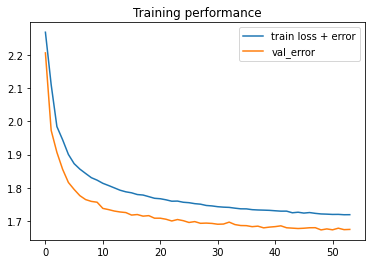

In [14]:
evaluationlib.show_loss_curves(history)

## Confusion matrix

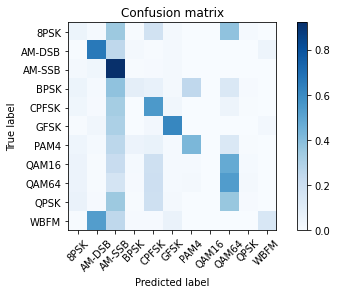

In [15]:
evaluationlib.plot_confusion_matrix(model, X_test, Y_test, BATCH_SIZE, classes)

## Confusion matrix for each SNR

Overall Accuracy:  0.08543833580980684
Overall Accuracy:  0.09463955637707948


Overall Accuracy:  0.09508660303994344
Overall Accuracy:  0.10576247364722417


Overall Accuracy:  0.1315028901734104
Overall Accuracy:  0.17937701396348013


Overall Accuracy:  0.23683267646005016


Overall Accuracy:  0.3241279069767442
Overall Accuracy:  0.4210152644657437


Overall Accuracy:  0.4895758447160316
Overall Accuracy:  0.4829339143064633


Overall Accuracy:  0.5099170573386225
Overall Accuracy:  0.5058823529411764


Overall Accuracy:  0.514179104477612


Overall Accuracy:  0.4935158501440922
Overall Accuracy:  0.5038279256288735


Overall Accuracy:  0.5164753794890781
Overall Accuracy:  0.509213990221888


Overall Accuracy:  0.5184229918938835
Overall Accuracy:  0.5329749103942653


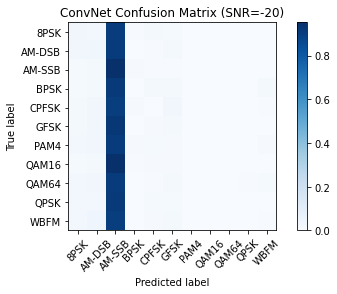

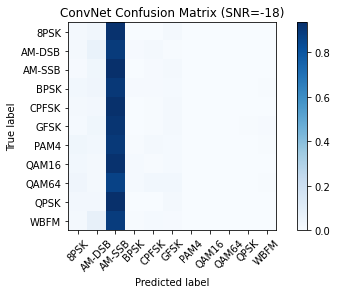

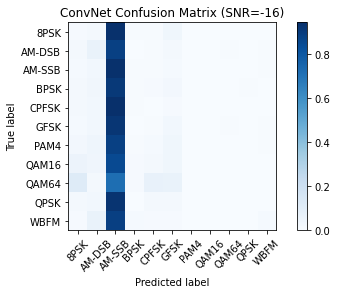

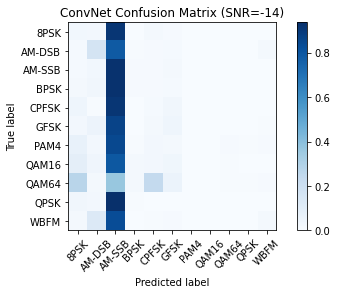

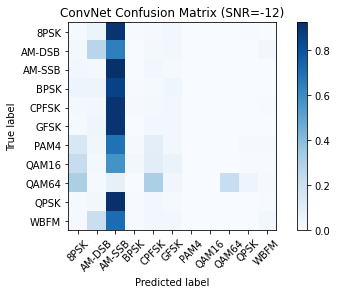

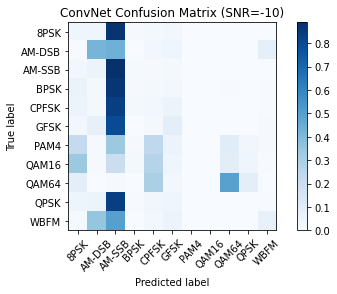

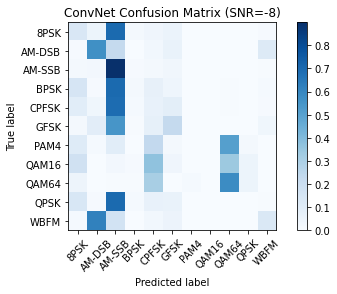

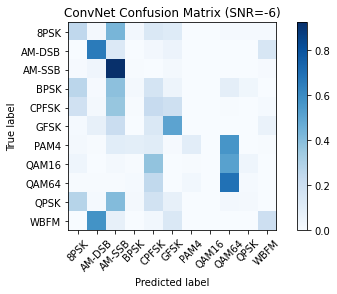

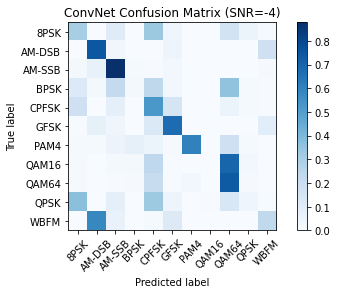

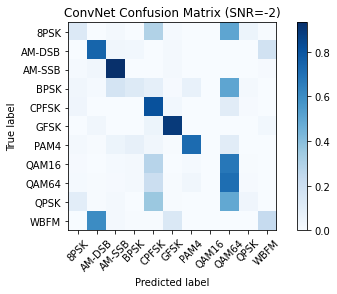

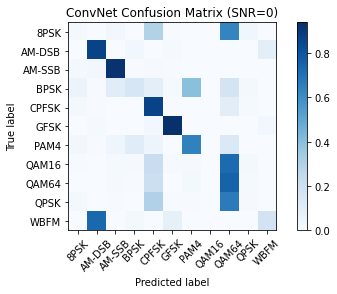

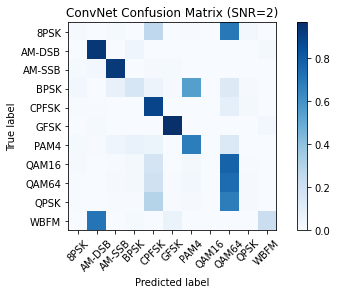

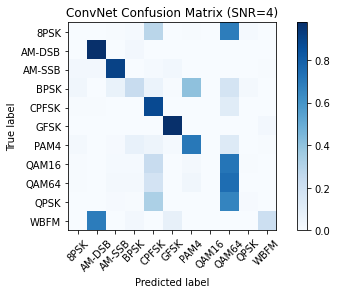

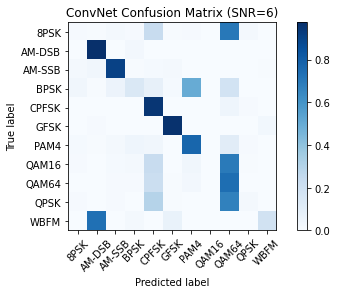

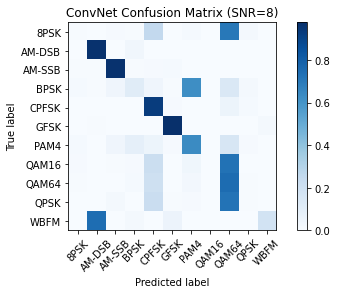

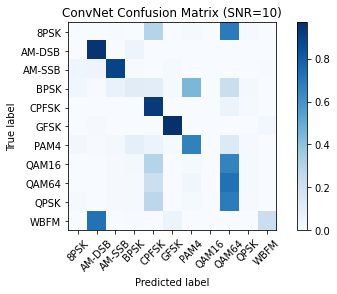

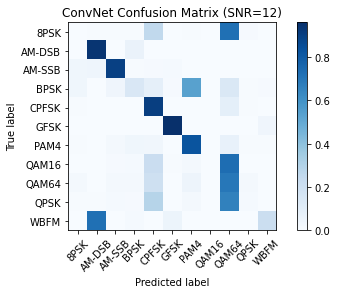

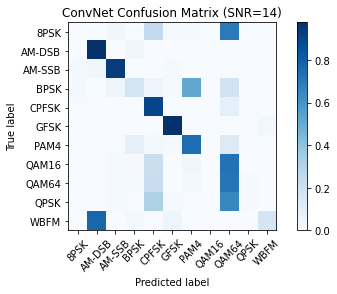

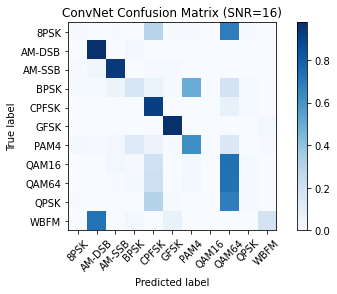

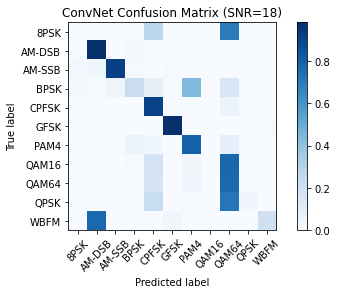

In [16]:
acc = evaluationlib.plot_confusion_matrix_each_snr(model, snrs, dataset_df, X_test, Y_test, test_index, classes)

## Accuracy performance

In [17]:
evaluationlib.accuracy_dataframe(acc)

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
Accuracy %,8,9,9,10,13,17,23,32,42,48,48,50,50,51,49,50,51,50,51,53


In [18]:
# Save results to a pickle file for plotting later
# fd = open(OUTPUT_FILENAME,'wb')
# pickle.dump( ("CNN2", 0.5, acc) , fd )

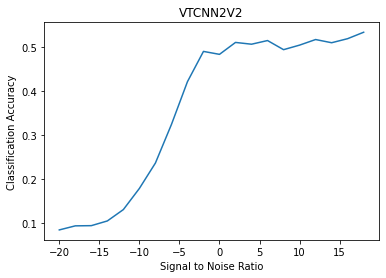

In [19]:
evaluationlib.accuracy_curve(snrs, acc, NEURAL_NETWORK_NAME)